In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array

In [2]:
TRAIN_DIR = r'c:/users/adeog/Desktop/indian_coins_dataset/train'
VALIDATION_DIR = r'c:/users/adeog/Desktop/indian_coins_dataset/val'

TEST_DIR = r'c:/users/adeog/Desktop/indian_coins_dataset/test'
print("Number of coin's category: ",len(os.listdir(TRAIN_DIR)))

Number of coin's category:  4


In [3]:
# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True)


datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True)

datagen_test = ImageDataGenerator(
    rescale=1./255)

In [4]:
train_batch_size = 64
test_batch_size = 30

train_generator = datagen_train.flow_from_directory(
        TRAIN_DIR,
        target_size=(224,224),
        batch_size=train_batch_size,
        class_mode='categorical')

valid_generator = datagen_valid.flow_from_directory(
        VALIDATION_DIR,
        target_size=(224, 224),
        batch_size=test_batch_size,
        class_mode='categorical')

test_generator = datagen_test.flow_from_directory(
        TEST_DIR,
        target_size=(224,224),
        batch_size=test_batch_size,
        class_mode='categorical')

Found 109 images belonging to 4 classes.
Found 102 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


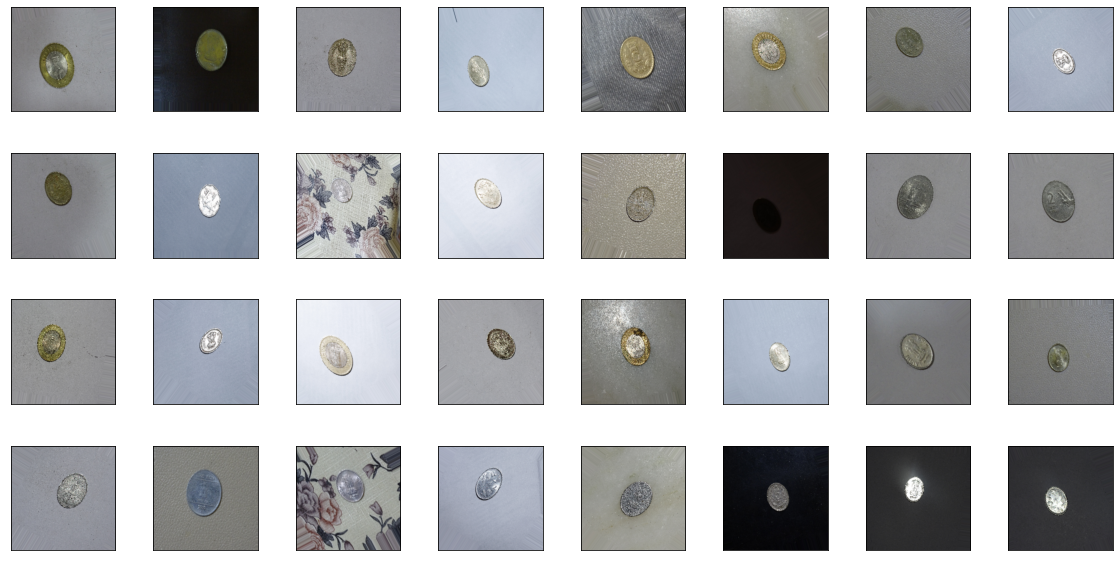

In [7]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Lets have a look at some of our images
images, labels = train_generator.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])

In [8]:
# from keras.applications import InceptionV3
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

In [9]:

# from keras.applications import InceptionV3
# from keras.layers import Dense, Input, Dropout
# from keras.models import Model


input_tensor = Input(shape=(224,224, 3))
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=(224,224, 3),
    pooling='avg')

for layer in base_model.layers:
    layer.trainable = True # trainable has to be false in order to freeze the layers

x = Dense(512, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)



predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

In [12]:
# num_train = len(train_generator.filenames)
# print(num_train)

num_test = len(test_generator.filenames)
print(num_test)

38


In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
num_train = len(train_generator.filenames)
num_valid = len(valid_generator.filenames)
num_test = len(test_generator.filenames)
# When to save the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
# Reduce learning rate when loss doesn't improve after n epochs
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)
# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=12,
                              verbose=0, restore_best_weights=True)
# Train the model using Inception V3
history = model.fit(train_generator,
                    steps_per_epoch=num_train//train_batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//test_batch_size)

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 1.4477 - accuracy: 0.2188
Epoch 00001: val_loss improved from inf to 1.43715, saving model to model.weights.best.hdf5
1/1 [==============================] - 67s 67s/step - loss: 1.4477 - accuracy: 0.2188 - val_loss: 1.4372 - val_accuracy: 0.2889
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 1.3062 - accuracy: 0.4889
Epoch 00002: val_loss did not improve from 1.43715
1/1 [==============================] - 46s 46s/step - loss: 1.3062 - accuracy: 0.4889 - val_loss: 1.4738 - val_accuracy: 0.2222
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 1.2715 - accuracy: 0.4531
Epoch 00003: val_loss did not improve from 1.43715
1/1 [==============================] - 45s 45s/step - loss: 1.2715 - accuracy: 0.4531 - val_loss: 1.4568 - val_accuracy: 0.2444
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 1.2235 - accuracy: 0.5111
Epoch 00004: val_loss improved from 1.43715 to 1.38175

Epoch 30/30
1/1 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.9688
Epoch 00030: val_loss improved from 1.25195 to 1.18716, saving model to model.weights.best.hdf5
1/1 [==============================] - 50s 50s/step - loss: 0.2750 - accuracy: 0.9688 - val_loss: 1.1872 - val_accuracy: 0.5556


In [14]:
import torch
model.save('Inception_coin.h5')
# model_save_name = 'Inception_coin.h5'
# path = F"/content/drive/MyDrive/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [16]:
score = model.evaluate_generator(test_generator, steps=num_test//1, verbose=1)
print('\n', 'Test accuracy:', score[1])

 2/38 [>.............................] - 3s 1s/step - loss: 1.2209 - accuracy: 0.5526

 Test accuracy: 0.5526315569877625


In [ ]:
# def normalizer(img):
#     img_expand = np.expand_dims(img, axis=0)

#     generator = ImageDataGenerator(
#         featurewise_std_normalization=True,
#         samplewise_std_normalization=True,
#         rescale=1./255)
#     image_flow = generator.flow(
#         img_expand,
#         y=None,
#         batch_size=1
#     )
    
#     return image_flow.next()

In [ ]:
int_to_dir = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
plt.figure(figsize=(20,12))

print("\n\t\t\t\tEvolution of Loss and Accuracy through the Epochs (Qtd: " + str(20) + ")")

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='val loss')
plt.title("Accuracy")
plt.legend()

plt.show()

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.preprocessing import image
predict_list=[]
truth_list=[]
def get_prediction(img, real_label):
    img = image.img_to_array(img)/255   #black and white
    
    # mean = [0.485, 0.456, 0.406]        #Red mean Green mean Blue mean
    # std = [0.229, 0.224, 0.225]         
    # img = (img - mean)/std
    # print(img)
    # print(real_label.image_shape)
    m = tf.keras.metrics.Mean()
    m.update_state(img[:,:,0])
    red=m.result().numpy()
    m.update_state(img[:,:,1])
    green=m.result().numpy()
    m.update_state(img[:,:,2])
    blue=m.result().numpy()
    mean=[red,green,blue]
    # print(mean)
    r_std=np.std(img[:,:,0])
    g_std=np.std(img[:,:,1])
    b_std=np.std(img[:,:,2])
    std=[r_std,g_std,b_std]
    # print(std)
    img = (img - mean)/std


    img_expand = np.expand_dims(img,axis=0)
    # print(img_expand.shape)

    prediction = model.predict(img_expand)
    # print(prediction)
    prediction_int = np.argmax(prediction)   #Returns the indices of the maximum values along an axis.

    dir_int = int_to_dir[prediction_int]
    # print(dir_int)
    # label_name= ['rupee_1','rupee_10','rupee_2','rupee_5']
    # for i in range(4):

    label_name = str(dir_int)
    print(label_name)
  
    print(real_label)
    # print(prediction_int)
    
    plt.imshow(img)
    
    
    print("Predicted: {}\n Ground truth:      {}".format(label_name, str(real_label)))
    print()
    # plt.imshow(predictions)
    # plt.imshow(real_label)
    
    
    # print(prediction.shape)
    # prediction.reshape(224,)
    # print(test_generator.image_shape)
    # t='/content/drive/MyDrive/IndianCoin/indian_coins_dataset/test'
    # print(t.shape)
    # print(test)
    # cm = confusion_matrix(, prediction)
    # sns.heatmap(cm, annot=True)
    # predict_value=list(label_name)
    # y_truth=list(real_label)
    
    predict_list.append(label_name)
    truth_list.append(real_label)
    

    

for i in range(10):
    random_index = np.random.randint(0, len(test_generator.filenames))
    # print(random_index)
    img = test_generator.filenames[random_index]
    img = image.load_img("c:/users/adeog/Desktop/indian_coins_dataset/test/"+img, target_size=(224,224))
    # plt.imshow(img)
    
    real_label = test_generator.filenames[random_index].split("/")[0]
    # plt.imshow(real_label)
    # print(real_label)
    get_prediction(img, real_label)


In [ ]:
cm=confusion_matrix(predict_list,truth_list)
print(cm)
# print(predict_list)
print(cm[0][0])

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()